In [1]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import gc
import multiprocessing as mp
import numpy as np
import pandas as pd
import _pickle as cpickle
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [2]:
order = pd.read_csv('data/orders.csv')
train = pd.read_csv('data/order_products__train.csv')

In [3]:
user_df = pd.read_pickle('data/user_df.pkl')
product_df = pd.read_pickle('data/product_df.pkl')
purchase_df = pd.read_pickle('data/purchase_df.pkl').reset_index()

In [4]:
data = purchase_df.merge(user_df, on='user_id', how='left')
data = data.merge(product_df, on='product_id', how='left')

In [5]:
data.shape

(13307953, 26)

In [6]:
## train test 데이터 셋 

In [7]:
future_orders = order[((order['eval_set']=='train') | (order['eval_set']=='test'))]
future_orders = future_orders[['user_id','order_id','eval_set']]

In [8]:
data = data.merge(future_orders, on='user_id',how='left')
train_df = data[data['eval_set']=='train']
train_df = train_df.merge(train[['product_id','order_id','reordered']], on=['product_id','order_id'], how='left')
train_df['reordered'] = train_df['reordered'].fillna(0)
train_df = train_df.set_index(['user_id','product_id'])
train_df.drop(['eval_set','order_id'],axis=1, inplace=True)
train_df.fillna(train_df.mean(), inplace=True)

In [9]:
# 테스트 데이터 셋


In [10]:
test_df = data[data['eval_set']=='test']
test_df = test_df.set_index(['user_id','product_id'])
test_df.drop(['eval_set','order_id'],axis=1, inplace=True)

In [11]:
from downcast import reduce

In [12]:
train_df = reduce(train_df)

In [13]:
y = train_df['reordered']
X = train_df.drop(['reordered','min_num_order'],axis=1)

In [14]:
X_train , X_val , y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=10, stratify=y)

In [28]:
import pdb
from sklearn.ensemble import RandomForestClassifier
def get_imp_features(data,data_y,features):
    clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=10)
    clf.fit(data,data_y)
    imp_feature_indexes = np.argsort(clf.feature_importances_)[::-1]
    top_indexes = imp_feature_indexes
    feature_imp_values = np.take(clf.feature_importances_,top_indexes)
    feature_imp_names = np.take(features,top_30_indexes)
    return feature_imp_values,feature_imp_names,top_30_indexes

In [29]:
features = X_train.columns.tolist()
feature_imp_values,feature_imp_names,top_30_indexes = get_imp_features(X_train,y_train, features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.3s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.8s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   54.1s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.7min


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.2min


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.3min


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.4min


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.1min remaining:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


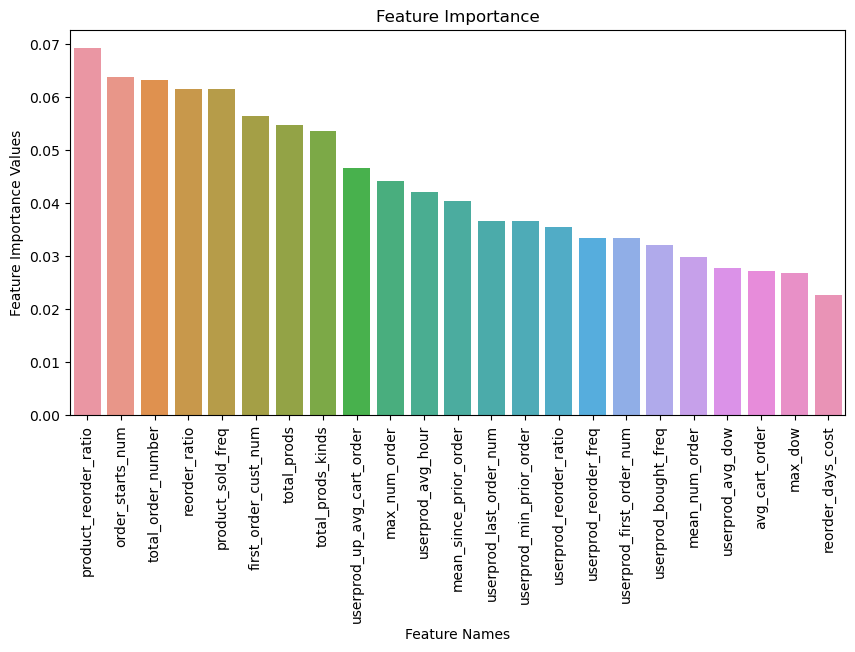

In [30]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = feature_imp_names, y = feature_imp_values)
ax.set_xticklabels(labels = feature_imp_names, rotation = 90)
sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
plt.title('Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance Values')
plt.show()

In [46]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [32]:
from sklearn.model_selection import RandomizedSearchCV

params = {'C' : [0.001,0.01,1,10] }

lr_model=LogisticRegression(penalty='l2',class_weight='balanced')
random_cfl=RandomizedSearchCV(lr_model,param_distributions=params,verbose=10,cv=4)
random_cfl.fit(X_train,y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START C=0.001.....................................................
[CV 1/4; 1/4] END ......................C=0.001;, score=0.669 total time=   4.9s
[CV 2/4; 1/4] START C=0.001.....................................................
[CV 2/4; 1/4] END ......................C=0.001;, score=0.680 total time=   7.4s
[CV 3/4; 1/4] START C=0.001.....................................................
[CV 3/4; 1/4] END ......................C=0.001;, score=0.669 total time=  13.9s
[CV 4/4; 1/4] START C=0.001.....................................................
[CV 4/4; 1/4] END ......................C=0.001;, score=0.665 total time=  14.7s
[CV 1/4; 2/4] START C=0.01......................................................
[CV 1/4; 2/4] END .......................C=0.01;, score=0.669 total time=   5.1s
[CV 2/4; 2/4] START C=0.01......................................................
[CV 2/4; 2/4] END .......................C=0.01;,

RandomizedSearchCV(cv=4, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [0.001, 0.01, 1, 10]}, verbose=10)

In [33]:
# Best Paramaters
random_cfl.best_params_

{'C': 0.01}

### To get the f1 score for different thresholds


In [36]:
# To get the best threshold for max F1 score

# Initializing the model
lr_model = LogisticRegression(C=0.001)
lr_model.fit(X_train, y_train)
thresholds = lr_model.predict_proba(X_val)[:, 1]

In [37]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [38]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)

0.11441626917785813
0.08878978694755113
0.2919958430729604
-0.06316330471724413


In [42]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (lr_model.predict_proba(X_val)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_val , y_pred))

In [45]:
threshold_values

array([-0.0631633, -0.0431633, -0.0231633, -0.0031633,  0.0168367,
        0.0368367,  0.0568367,  0.0768367,  0.0968367,  0.1168367,
        0.1368367,  0.1568367,  0.1768367,  0.1968367,  0.2168367,
        0.2368367,  0.2568367,  0.2768367])

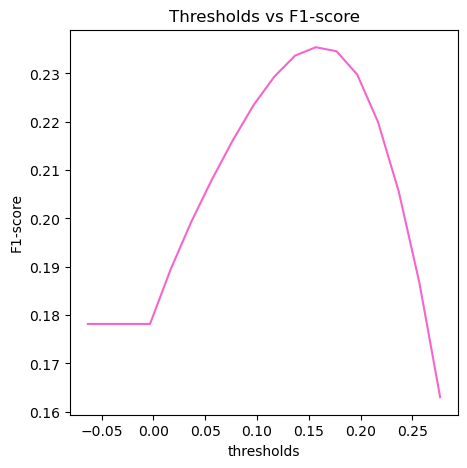

In [46]:
plt.figure(figsize=(5,5))
sns.lineplot(x= threshold_values , y=f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()

In [47]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.1568366952827559
Best F1-Score:  0.23541528541322346


### 모델 평가 

Train F1 Score: 0.23216128843794429
Validation F1 Score: 0.23197431654124878
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.92      0.88   2086468
           1       0.33      0.18      0.23    455931

    accuracy                           0.79   2542399
   macro avg       0.58      0.55      0.55   2542399
weighted avg       0.75      0.79      0.76   2542399

--------------------------------------------------


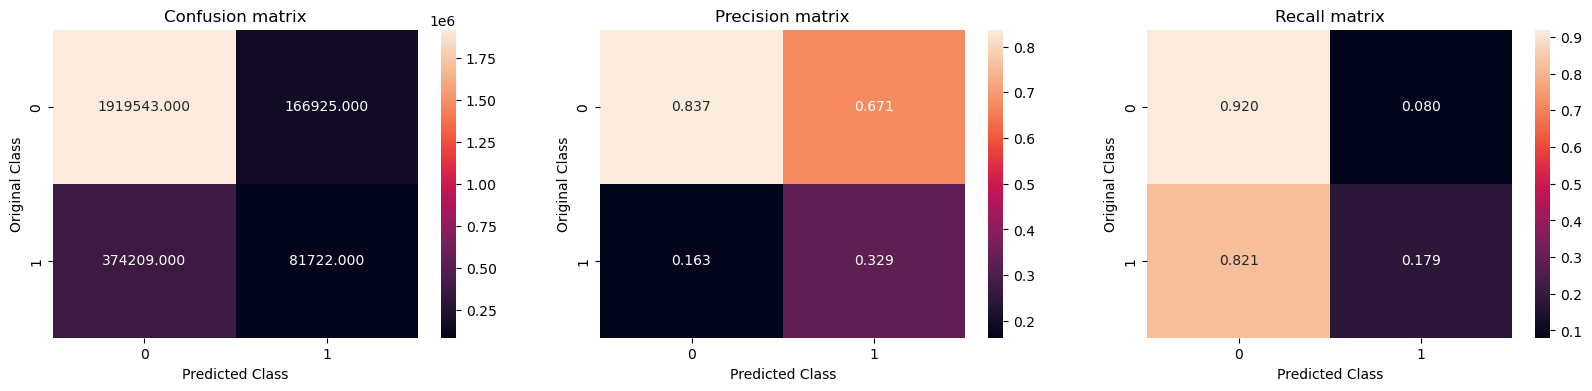

In [51]:
lr_model = LogisticRegression(C=0.001)
lr_model.fit(X_train, y_train)

train_pred_y = (lr_model.predict_proba(X_train)[:, 1] >= 0.19).astype('int')
test_pred_y = (lr_model.predict_proba(X_val)[:, 1] >= 0.19).astype('int')

f1_train = f1_score(train_pred_y, y_train)
f1_test = f1_score(test_pred_y, y_val)

print("Train F1 Score:", f1_train)
print("Validation F1 Score:", f1_test)
print("-"*50)
print(classification_report(test_pred_y, y_val))
print("-"*50)
plot_confusion_matrix(test_pred_y, y_val)

### XGBoost 
HyperParameter Tuning

In [21]:

# xgb_model = xgb.XGBClassifier(booster='gbtree',
#                               scale_pos_weight=1,
#                               learning_rate=0.15,  
#                               min_child_weigh=7,
#                               colsample_bytree = 0.5,
#                               subsample = 0.7,
#                               objective='binary:logistic', 
#                               n_estimators=100, 
#                               max_depth=6, 
#                               gamma=0.2, 
#                               seed=777)
xgb_model2 = xgb.XGBClassifier(booster='gbtree',
                              scale_pos_weight=1,
                              learning_rate=0.15,  
                              min_child_weight=7,
                              colsample_bytree = 0.5,
                              subsample = 0.7,
                              objective='binary:logistic', 
                              n_estimators=100, 
                              max_depth=6, 
                              gamma=0.2, 
                              seed=777)

In [22]:
hr_pred = xgb_model2.fit(X_train, y_train).predict(X_val)
print(classification_report(y_val, hr_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95   2293752
         1.0       0.63      0.15      0.24    248647

    accuracy                           0.91   2542399
   macro avg       0.77      0.57      0.60   2542399
weighted avg       0.89      0.91      0.88   2542399



In [23]:
# To get the best threshold for max F1 score

# Initializing the model

thresholds = xgb_model2.predict_proba(X_val)[:, 1]

In [24]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [25]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)

0.09787375
0.12518969
0.34825313091278076
-0.15250563621520996


### CatBoost



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

params = {'depth':[3,4,5,7,8,10,12],
          'iterations':[250,100,500,1000]}

cbc_model=CatBoostClassifier(boosting_type='Plain',bootstrap_type='Bernoulli')
random_cfl=RandomizedSearchCV(cbc_model,param_distributions=params,verbose=10,cv=3)
y_train = y_train.astype('int')
random_cfl.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START depth=4, iterations=500....................................
Learning rate set to 0.5
0:	learn: 0.3504687	total: 202ms	remaining: 1m 40s
1:	learn: 0.2880741	total: 336ms	remaining: 1m 23s
2:	learn: 0.2746893	total: 488ms	remaining: 1m 20s
3:	learn: 0.2683405	total: 618ms	remaining: 1m 16s
4:	learn: 0.2655573	total: 749ms	remaining: 1m 14s
5:	learn: 0.2640007	total: 875ms	remaining: 1m 12s
6:	learn: 0.2621820	total: 1.01s	remaining: 1m 10s
7:	learn: 0.2607696	total: 1.14s	remaining: 1m 9s
8:	learn: 0.2602832	total: 1.25s	remaining: 1m 8s
9:	learn: 0.2596464	total: 1.38s	remaining: 1m 7s
10:	learn: 0.2587326	total: 1.51s	remaining: 1m 7s
11:	learn: 0.2578273	total: 1.66s	remaining: 1m 7s
12:	learn: 0.2572525	total: 1.78s	remaining: 1m 6s
13:	learn: 0.2569095	total: 1.9s	remaining: 1m 6s
14:	learn: 0.2566815	total: 2.02s	remaining: 1m 5s
15:	learn: 0.2560721	total: 2.15s	remaining: 1m 5s
16:	learn: 0.2555965	

In [27]:
random_cfl.best_params_

{'iterations': 1000, 'depth': 5}

In [30]:
catboost_model = CatBoostClassifier(depth=5,iterations=1000)
y_train = y_train.astype('int')
catboost_model.fit(X_train,y_train)
thresholds = catboost_model.predict_proba(X_val)[:, 1]

Learning rate set to 0.420823
0:	learn: 0.3741375	total: 277ms	remaining: 4m 36s
1:	learn: 0.3008526	total: 499ms	remaining: 4m 8s
2:	learn: 0.2801523	total: 742ms	remaining: 4m 6s
3:	learn: 0.2694756	total: 987ms	remaining: 4m 5s
4:	learn: 0.2637709	total: 1.24s	remaining: 4m 6s
5:	learn: 0.2614746	total: 1.49s	remaining: 4m 6s
6:	learn: 0.2598035	total: 1.73s	remaining: 4m 5s
7:	learn: 0.2588644	total: 1.97s	remaining: 4m 4s
8:	learn: 0.2579660	total: 2.21s	remaining: 4m 3s
9:	learn: 0.2571373	total: 2.44s	remaining: 4m 1s
10:	learn: 0.2563349	total: 2.68s	remaining: 4m
11:	learn: 0.2559016	total: 2.91s	remaining: 3m 59s
12:	learn: 0.2555255	total: 3.15s	remaining: 3m 59s
13:	learn: 0.2551886	total: 3.37s	remaining: 3m 57s
14:	learn: 0.2548015	total: 3.58s	remaining: 3m 55s
15:	learn: 0.2545093	total: 3.82s	remaining: 3m 54s
16:	learn: 0.2542015	total: 4.04s	remaining: 3m 53s
17:	learn: 0.2539110	total: 4.27s	remaining: 3m 53s
18:	learn: 0.2537761	total: 4.47s	remaining: 3m 50s
19:	l

In [31]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [32]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)

0.09784871589924397
0.13195045735010377
0.36174963059945153
-0.16605219880096356


In [35]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (catboost_model.predict_proba(X_val)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_val , y_pred))

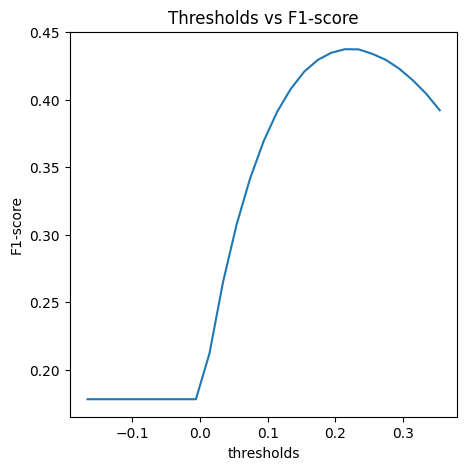

In [37]:
plt.figure(figsize=(5,5))
sns.lineplot(x = threshold_values , y = f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()

In [38]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.21394780119903625
Best F1-Score:  0.4374243060342668


In [ ]:
###Model Evaluation



In [39]:
# Initializing the model
catboost_model = CatBoostClassifier(depth=5,iterations=1000)

#fitting the model.
y_train = y_train.astype('int')
catboost_model.fit(X_train, y_train)

#prediction
y_pred_train = (catboost_model.predict_proba(X_train)[:, 1] >= 0.21).astype('int') #setting a threshold.
y_pred_test = (catboost_model.predict_proba(X_val)[:, 1] >= 0.21).astype('int') #setting a threshold.

Learning rate set to 0.420823
0:	learn: 0.3741375	total: 273ms	remaining: 4m 32s
1:	learn: 0.3008526	total: 502ms	remaining: 4m 10s
2:	learn: 0.2801523	total: 745ms	remaining: 4m 7s
3:	learn: 0.2694756	total: 989ms	remaining: 4m 6s
4:	learn: 0.2637709	total: 1.24s	remaining: 4m 6s
5:	learn: 0.2614746	total: 1.47s	remaining: 4m 4s
6:	learn: 0.2598035	total: 1.71s	remaining: 4m 2s
7:	learn: 0.2588644	total: 1.95s	remaining: 4m 1s
8:	learn: 0.2579660	total: 2.19s	remaining: 4m 1s
9:	learn: 0.2571373	total: 2.41s	remaining: 3m 58s
10:	learn: 0.2563349	total: 2.65s	remaining: 3m 58s
11:	learn: 0.2559016	total: 2.88s	remaining: 3m 57s
12:	learn: 0.2555255	total: 3.12s	remaining: 3m 56s
13:	learn: 0.2551886	total: 3.33s	remaining: 3m 54s
14:	learn: 0.2548015	total: 3.55s	remaining: 3m 53s
15:	learn: 0.2545093	total: 3.78s	remaining: 3m 52s
16:	learn: 0.2542015	total: 4.03s	remaining: 3m 52s
17:	learn: 0.2539110	total: 4.28s	remaining: 3m 53s
18:	learn: 0.2537761	total: 4.51s	remaining: 3m 52s

NameError: name 'X_test' is not defined

In [ ]:
# Initializing the model
catboost_model = CatBoostClassifier(depth=5,iterations=1000)

#fitting the model.
y_train = y_train.astype('int')
catboost_model.fit(X_train, y_train)

#prediction
y_pred_train = (catboost_model.predict_proba(X_train)[:, 1] >= 0.21).astype('int') #setting a threshold.
y_pred_test = (catboost_model.predict_proba(X_val)[:, 1] >= 0.21).astype('int') #setting a threshold.

In [43]:
y_pred_train = (catboost_model.predict_proba(X_train)[:, 1] >= 0.21).astype('int') #setting a threshold.
y_pred_test = (catboost_model.predict_proba(X_val)[:, 1] >= 0.21).astype('int') #setting a threshold.

In [44]:
#Evaluation.
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_val)))
print("-"*50)
print(classification_report(y_pred_test, y_val))

Train F1 Score: 0.44480866247588496
Validation F1 Score: 0.43709930092340843
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93   2204415
           1       0.52      0.38      0.44    337984

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



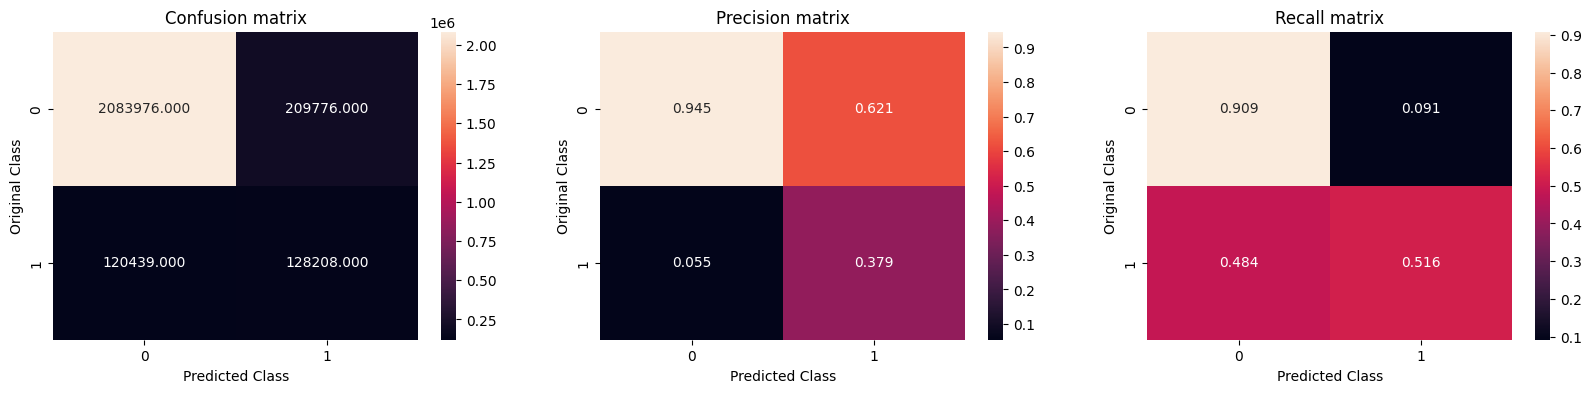

In [48]:
# Confusion, Precision and Recall matrix
plot_confusion_matrix(y_val,y_pred_test)

In [50]:
import pickle
pickle.dump(catboost_model, open("model/catboost_model", 'wb'))

In [51]:
### light gbm

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
'num_leaves': list(range(8, 92, 4)),
'max_depth': [3, 4, 5, 6, 8, 10,12],
'learning_rate': [0.1, 0.05, 0.01, 0.005],
}

lgb_model=lgb.LGBMClassifier(boosting_type='gbdt',objective='binary')
random_cfl=RandomizedSearchCV(lgb_model,param_distributions=param_grid,verbose=10,n_jobs=-1)
random_cfl.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5; 2/10] START learning_rate=0.005, max_depth=4, num_leaves=8.............
[LightGBM] [Info] Number of positive: 464142, number of negative: 4281668
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 4745810, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221907
[LightGBM] [Info] Start training from score -2.221907
[CV 3/5; 2/10] END learning_rate=0.005, max_depth=4, num_leaves=8;, score=0.902 total time=  48.7s
[CV 4/5; 2/10] START learning_rate=0.005, max_depth=4, num_leaves=8.............
[LightGBM] [Info] Number of positive: 464142, number of negative: 4281668
[LightGBM] [Warning] Auto-choosing row

RandomizedSearchCV(estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01,
                                                          0.005],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12],
                                        'num_leaves': [8, 12, 16, 20, 24, 28,
                                                       32, 36, 40, 44, 48, 52,
                                                       56, 60, 64, 68, 72, 76,
                                                       80, 84, 88]},
                   verbose=10)

In [52]:
# To get the best threshold for max F1 score
# Initializing the model
lgbm = lgb.LGBMClassifier(objective='binary', num_leaves=80, max_depth=6,learning_rate=0.1)
lgbm.fit(X_train,y_train)


[LightGBM] [Info] Number of positive: 580177, number of negative: 5352085
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 5932262, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221908
[LightGBM] [Info] Start training from score -2.221908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

NameError: name 'X_test' is not defined

In [53]:
thresholds = lgbm.predict_proba(X_val)[:, 1]
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [54]:
 # To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)

0.09788822335455812
0.12467524567194263
0.34723871469844336
-0.15146226798932716


In [56]:
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (lgbm.predict_proba(X_val)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_val , y_pred))

[CV 1/5; 5/10] START learning_rate=0.1, max_depth=12, num_leaves=20.............
[LightGBM] [Info] Number of positive: 464141, number of negative: 4281668
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.484787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 4745809, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221910
[LightGBM] [Info] Start training from score -2.221910
[CV 1/5; 5/10] END learning_rate=0.1, max_depth=12, num_leaves=20;, score=0.908 total time= 2.4min
[CV 2/5; 6/10] START learning_rate=0.1, max_depth=5, num_leaves=76..............
[LightGBM] [Info] Number of positive: 464141, number of negative: 4281668
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.718954 s

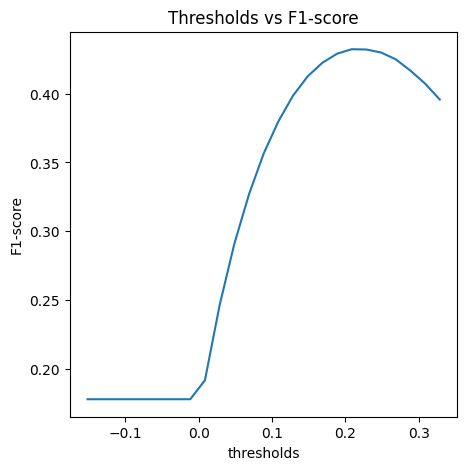

In [58]:
plt.figure(figsize=(5,5))
sns.lineplot(x= threshold_values , y = f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()

In [59]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.20853773201067266
Best F1-Score:  0.4322073207963445


**<h4> Model Evaluation**

In [60]:
# best parameters 
random_cfl.best_params_

{'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.1}

In [61]:
# Creating a light gradient boosting model.
from sklearn.metrics import f1_score, classification_report

# Initializing the model
lgbm = lgb.LGBMClassifier(objective='binary', num_leaves=20, max_depth=12,learning_rate=0.1)

# fitting the model.
lgbm.fit(X_train, y_train)

# prediction
# Taking the best threshold as 0.21 from above
y_pred_train = (lgbm.predict_proba(X_train)[:, 1] >= 0.216).astype('int') #setting a threshold.
y_pred_test = (lgbm.predict_proba(X_val)[:, 1] >= 0.216).astype('int') #setting a threshold.

# Evaluation
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_val)))
print("-"*50)
print(classification_report(y_pred_test, y_val))

[LightGBM] [Info] Number of positive: 580177, number of negative: 5352085
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 5932262, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221908
[LightGBM] [Info] Start training from score -2.221908
Train F1 Score: 0.4319708011960529
Validation F1 Score: 0.4301189994751288
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2209951
           1       0.50      0.38      0.43    332448

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87   

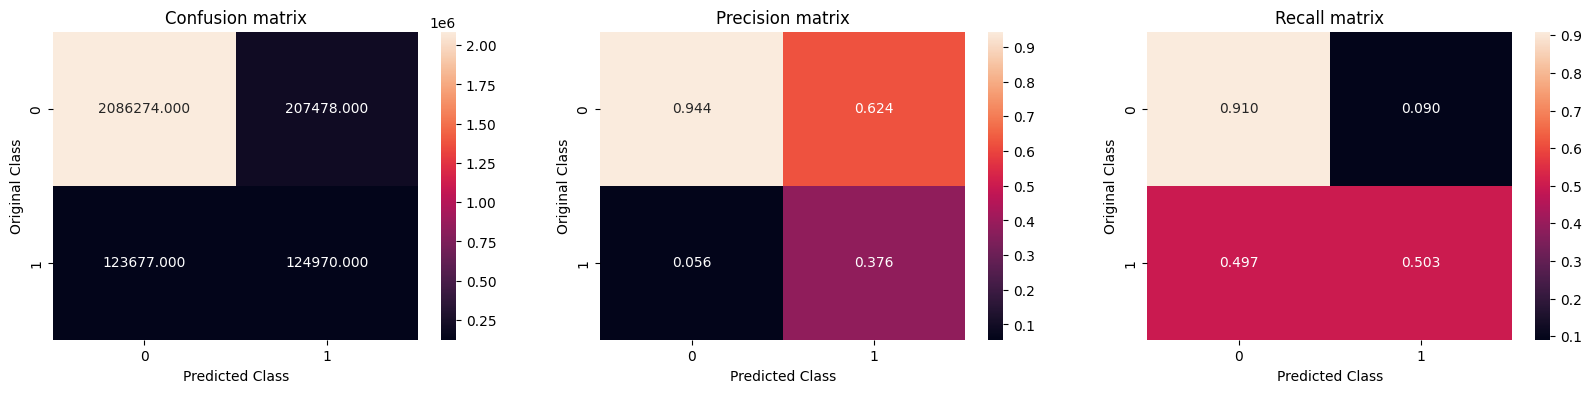

In [62]:
# Confusion, Precision and Recall matrix
plot_confusion_matrix(y_val,y_pred_test)

In [63]:
pickle.dump(lgbm, open("model/lgbm_model", 'wb'))

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [3,5,7],
    'min_samples_split' : [2, 5, 10, 15],
    'min_samples_leaf' :  [1, 2, 5, 10] 
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3; 2/10] START max_depth=7, min_samples_leaf=1, min_samples_split=10......
[CV 3/3; 2/10] END max_depth=7, min_samples_leaf=1, min_samples_split=10;, score=0.905 total time=19.7min
[CV 2/3; 5/10] START max_depth=5, min_samples_leaf=10, min_samples_split=2......
[CV 2/3; 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=2;, score=0.902 total time=12.5min
[CV 1/3; 9/10] START max_depth=3, min_samples_leaf=10, min_samples_split=10.....
[CV 1/3; 9/10] END max_depth=3, min_samples_leaf=10, min_samples_split=10;, score=0.902 total time= 8.2min
[CV 2/3; 2/10] START max_depth=7, min_samples_leaf=1, min_samples_split=10......
[CV 2/3; 2/10] END max_depth=7, min_samples_leaf=1, min_samples_split=10;, score=0.905 total time=19.7min
[CV 3/3; 5/10] START max_depth=5, min_samples_leaf=10, min_samples_split=2......
[CV 3/3; 5/10] END max_depth=5, min_samples_leaf=10, min_samples_split=2;, score=0.902 total time=12.6min
[CV

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15]},
                   verbose=10)

In [65]:
# Best Parameters
random_search.best_params_

{'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 7}

In [66]:
# To get the best threshold for max F1 score

# Initializing the model
rfc_model = RandomForestClassifier(n_estimators=800,max_depth=7,min_samples_leaf=2,min_samples_split=10,n_jobs=-1,verbose=10)
rfc_model.fit(X_train,y_train)
thresholds = rfc_model.predict_proba(X_val)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 800building tree 2 of 800

building tree 3 of 800
building tree 4 of 800
building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s


building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.9s


building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.9s


building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.4s


building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.7s


building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 800
building tree 47 of 800
building tree 48 of 800
building tree 49 of 800
building tree 50 of 800
building tree 51 of 800
building tree 52 of 800
building tree 53 of 800


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min


building tree 54 of 800
building tree 55 of 800
building tree 56 of 800
building tree 57 of 800
building tree 58 of 800
building tree 59 of 800
building tree 60 of 800
building tree 61 of 800
building tree 62 of 800
building tree 63 of 800
building tree 64 of 800


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min


building tree 65 of 800
building tree 66 of 800
building tree 67 of 800
building tree 68 of 800
building tree 69 of 800
building tree 70 of 800
building tree 71 of 800
building tree 72 of 800
building tree 73 of 800
building tree 74 of 800
building tree 75 of 800
building tree 76 of 800
building tree 77 of 800


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.5min


building tree 78 of 800
building tree 79 of 800
building tree 80 of 800
building tree 81 of 800
building tree 82 of 800
building tree 83 of 800
building tree 84 of 800
building tree 85 of 800
building tree 86 of 800
building tree 87 of 800
building tree 88 of 800
building tree 89 of 800
building tree 90 of 800


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min


building tree 91 of 800
building tree 92 of 800
building tree 93 of 800
building tree 94 of 800
building tree 95 of 800
building tree 96 of 800
building tree 97 of 800
building tree 98 of 800
building tree 99 of 800
building tree 100 of 800
building tree 101 of 800
building tree 102 of 800
building tree 103 of 800
building tree 104 of 800
building tree 105 of 800


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.2min


building tree 106 of 800
building tree 107 of 800
building tree 108 of 800
building tree 109 of 800
building tree 110 of 800
building tree 111 of 800
building tree 112 of 800
building tree 113 of 800
building tree 114 of 800
building tree 115 of 800
building tree 116 of 800
building tree 117 of 800
building tree 118 of 800
building tree 119 of 800
building tree 120 of 800


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.4min


building tree 121 of 800
building tree 122 of 800
building tree 123 of 800
building tree 124 of 800
building tree 125 of 800
building tree 126 of 800
building tree 127 of 800
building tree 128 of 800
building tree 129 of 800
building tree 130 of 800
building tree 131 of 800
building tree 132 of 800
building tree 133 of 800
building tree 134 of 800
building tree 135 of 800
building tree 136 of 800
building tree 137 of 800
building tree 138 of 800


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.9min


building tree 139 of 800
building tree 140 of 800
building tree 141 of 800
building tree 142 of 800
building tree 143 of 800
building tree 144 of 800
building tree 145 of 800
building tree 146 of 800
building tree 147 of 800
building tree 148 of 800
building tree 149 of 800
building tree 150 of 800
building tree 151 of 800
building tree 152 of 800
building tree 153 of 800
building tree 154 of 800
building tree 155 of 800
building tree 156 of 800


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min


building tree 157 of 800
building tree 158 of 800
building tree 159 of 800
building tree 160 of 800
building tree 161 of 800
building tree 162 of 800
building tree 163 of 800
building tree 164 of 800
building tree 165 of 800
building tree 166 of 800
building tree 167 of 800
building tree 168 of 800
building tree 169 of 800
building tree 170 of 800
building tree 171 of 800
building tree 172 of 800
building tree 173 of 800
building tree 174 of 800


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.7min


building tree 175 of 800
building tree 176 of 800
building tree 177 of 800
building tree 178 of 800
building tree 179 of 800
building tree 180 of 800
building tree 181 of 800
building tree 182 of 800
building tree 183 of 800
building tree 184 of 800
building tree 185 of 800
building tree 186 of 800
building tree 187 of 800
building tree 188 of 800
building tree 189 of 800
building tree 190 of 800
building tree 191 of 800
building tree 192 of 800


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min


building tree 193 of 800
building tree 194 of 800
building tree 195 of 800
building tree 196 of 800
building tree 197 of 800
building tree 198 of 800
building tree 199 of 800
building tree 200 of 800
building tree 201 of 800
building tree 202 of 800
building tree 203 of 800
building tree 204 of 800
building tree 205 of 800
building tree 206 of 800
building tree 207 of 800
building tree 208 of 800
building tree 209 of 800
building tree 210 of 800
building tree 211 of 800
building tree 212 of 800
building tree 213 of 800


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  5.0min


building tree 214 of 800
building tree 215 of 800
building tree 216 of 800
building tree 217 of 800
building tree 218 of 800
building tree 219 of 800
building tree 220 of 800
building tree 221 of 800
building tree 222 of 800
building tree 223 of 800
building tree 224 of 800
building tree 225 of 800
building tree 226 of 800
building tree 227 of 800
building tree 228 of 800
building tree 229 of 800
building tree 230 of 800
building tree 231 of 800
building tree 232 of 800
building tree 233 of 800
building tree 234 of 800


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  5.6min


building tree 235 of 800
building tree 236 of 800
building tree 237 of 800
building tree 238 of 800
building tree 239 of 800
building tree 240 of 800
building tree 241 of 800
building tree 242 of 800
building tree 243 of 800
building tree 244 of 800
building tree 245 of 800
building tree 246 of 800
building tree 247 of 800
building tree 248 of 800
building tree 249 of 800
building tree 250 of 800
building tree 251 of 800
building tree 252 of 800
building tree 253 of 800
building tree 254 of 800
building tree 255 of 800
building tree 256 of 800
building tree 257 of 800


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  6.3min


building tree 258 of 800
building tree 259 of 800
building tree 260 of 800
building tree 261 of 800
building tree 262 of 800
building tree 263 of 800
building tree 264 of 800
building tree 265 of 800
building tree 266 of 800
building tree 267 of 800
building tree 268 of 800
building tree 269 of 800
building tree 270 of 800
building tree 271 of 800
building tree 272 of 800
building tree 273 of 800
building tree 274 of 800
building tree 275 of 800
building tree 276 of 800
building tree 277 of 800
building tree 278 of 800
building tree 279 of 800
building tree 280 of 800


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.9min


building tree 281 of 800
building tree 282 of 800
building tree 283 of 800
building tree 284 of 800
building tree 285 of 800
building tree 286 of 800
building tree 287 of 800
building tree 288 of 800
building tree 289 of 800
building tree 290 of 800
building tree 291 of 800
building tree 292 of 800
building tree 293 of 800
building tree 294 of 800
building tree 295 of 800
building tree 296 of 800
building tree 297 of 800
building tree 298 of 800
building tree 299 of 800
building tree 300 of 800
building tree 301 of 800
building tree 302 of 800
building tree 303 of 800
building tree 304 of 800
building tree 305 of 800


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  7.7min


building tree 306 of 800
building tree 307 of 800
building tree 308 of 800
building tree 309 of 800
building tree 310 of 800
building tree 311 of 800
building tree 312 of 800
building tree 313 of 800
building tree 314 of 800
building tree 315 of 800
building tree 316 of 800
building tree 317 of 800
building tree 318 of 800
building tree 319 of 800
building tree 320 of 800
building tree 321 of 800
building tree 322 of 800
building tree 323 of 800
building tree 324 of 800
building tree 325 of 800
building tree 326 of 800
building tree 327 of 800
building tree 328 of 800
building tree 329 of 800
building tree 330 of 800


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  8.4min


building tree 331 of 800
building tree 332 of 800
building tree 333 of 800
building tree 334 of 800
building tree 335 of 800
building tree 336 of 800
building tree 337 of 800
building tree 338 of 800
building tree 339 of 800
building tree 340 of 800
building tree 341 of 800
building tree 342 of 800
building tree 343 of 800
building tree 344 of 800
building tree 345 of 800
building tree 346 of 800
building tree 347 of 800
building tree 348 of 800
building tree 349 of 800
building tree 350 of 800
building tree 351 of 800
building tree 352 of 800
building tree 353 of 800
building tree 354 of 800
building tree 355 of 800
building tree 356 of 800
building tree 357 of 800


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.2min


building tree 358 of 800
building tree 359 of 800
building tree 360 of 800
building tree 361 of 800
building tree 362 of 800
building tree 363 of 800
building tree 364 of 800
building tree 365 of 800
building tree 366 of 800
building tree 367 of 800
building tree 368 of 800
building tree 369 of 800
building tree 370 of 800
building tree 371 of 800
building tree 372 of 800
building tree 373 of 800
building tree 374 of 800
building tree 375 of 800
building tree 376 of 800
building tree 377 of 800
building tree 378 of 800
building tree 379 of 800
building tree 380 of 800
building tree 381 of 800
building tree 382 of 800
building tree 383 of 800
building tree 384 of 800


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 10.0min


building tree 385 of 800
building tree 386 of 800
building tree 387 of 800
building tree 388 of 800
building tree 389 of 800
building tree 390 of 800
building tree 391 of 800
building tree 392 of 800
building tree 393 of 800
building tree 394 of 800
building tree 395 of 800
building tree 396 of 800
building tree 397 of 800
building tree 398 of 800
building tree 399 of 800
building tree 400 of 800
building tree 401 of 800
building tree 402 of 800
building tree 403 of 800
building tree 404 of 800
building tree 405 of 800
building tree 406 of 800
building tree 407 of 800
building tree 408 of 800
building tree 409 of 800
building tree 410 of 800
building tree 411 of 800
building tree 412 of 800
building tree 413 of 800


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 11.0min


building tree 414 of 800
building tree 415 of 800
building tree 416 of 800
building tree 417 of 800
building tree 418 of 800
building tree 419 of 800
building tree 420 of 800
building tree 421 of 800
building tree 422 of 800
building tree 423 of 800
building tree 424 of 800
building tree 425 of 800
building tree 426 of 800
building tree 427 of 800
building tree 428 of 800
building tree 429 of 800
building tree 430 of 800
building tree 431 of 800
building tree 432 of 800
building tree 433 of 800
building tree 434 of 800
building tree 435 of 800
building tree 436 of 800
building tree 437 of 800
building tree 438 of 800
building tree 439 of 800
building tree 440 of 800
building tree 441 of 800
building tree 442 of 800


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.9min


building tree 443 of 800
building tree 444 of 800
building tree 445 of 800
building tree 446 of 800
building tree 447 of 800
building tree 448 of 800
building tree 449 of 800
building tree 450 of 800
building tree 451 of 800
building tree 452 of 800
building tree 453 of 800
building tree 454 of 800
building tree 455 of 800
building tree 456 of 800
building tree 457 of 800
building tree 458 of 800
building tree 459 of 800
building tree 460 of 800
building tree 461 of 800
building tree 462 of 800
building tree 463 of 800
building tree 464 of 800
building tree 465 of 800
building tree 466 of 800
building tree 467 of 800
building tree 468 of 800
building tree 469 of 800
building tree 470 of 800
building tree 471 of 800
building tree 472 of 800
building tree 473 of 800


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 12.8min


building tree 474 of 800
building tree 475 of 800
building tree 476 of 800
building tree 477 of 800
building tree 478 of 800
building tree 479 of 800
building tree 480 of 800
building tree 481 of 800
building tree 482 of 800
building tree 483 of 800
building tree 484 of 800
building tree 485 of 800
building tree 486 of 800
building tree 487 of 800
building tree 488 of 800
building tree 489 of 800
building tree 490 of 800
building tree 491 of 800
building tree 492 of 800
building tree 493 of 800
building tree 494 of 800
building tree 495 of 800
building tree 496 of 800
building tree 497 of 800
building tree 498 of 800
building tree 499 of 800
building tree 500 of 800
building tree 501 of 800
building tree 502 of 800
building tree 503 of 800
building tree 504 of 800


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 13.9min


building tree 505 of 800
building tree 506 of 800
building tree 507 of 800
building tree 508 of 800
building tree 509 of 800
building tree 510 of 800
building tree 511 of 800
building tree 512 of 800
building tree 513 of 800
building tree 514 of 800
building tree 515 of 800
building tree 516 of 800
building tree 517 of 800
building tree 518 of 800
building tree 519 of 800
building tree 520 of 800
building tree 521 of 800
building tree 522 of 800
building tree 523 of 800
building tree 524 of 800
building tree 525 of 800
building tree 526 of 800
building tree 527 of 800
building tree 528 of 800
building tree 529 of 800
building tree 530 of 800
building tree 531 of 800
building tree 532 of 800
building tree 533 of 800
building tree 534 of 800
building tree 535 of 800
building tree 536 of 800
building tree 537 of 800


[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 15.4min


building tree 538 of 800
building tree 539 of 800
building tree 540 of 800
building tree 541 of 800
building tree 542 of 800
building tree 543 of 800
building tree 544 of 800
building tree 545 of 800
building tree 546 of 800
building tree 547 of 800
building tree 548 of 800
building tree 549 of 800
building tree 550 of 800
building tree 551 of 800
building tree 552 of 800
building tree 553 of 800
building tree 554 of 800
building tree 555 of 800
building tree 556 of 800
building tree 557 of 800
building tree 558 of 800
building tree 559 of 800
building tree 560 of 800
building tree 561 of 800
building tree 562 of 800
building tree 563 of 800
building tree 564 of 800
building tree 565 of 800
building tree 566 of 800
building tree 567 of 800
building tree 568 of 800
building tree 569 of 800
building tree 570 of 800


[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 16.9min


building tree 571 of 800building tree 572 of 800

building tree 573 of 800
building tree 574 of 800
building tree 575 of 800
building tree 576 of 800
building tree 577 of 800
building tree 578 of 800
building tree 579 of 800
building tree 580 of 800
building tree 581 of 800
building tree 582 of 800
building tree 583 of 800
building tree 584 of 800
building tree 585 of 800
building tree 586 of 800
building tree 587 of 800
building tree 588 of 800
building tree 589 of 800
building tree 590 of 800
building tree 591 of 800
building tree 592 of 800
building tree 593 of 800
building tree 594 of 800
building tree 595 of 800
building tree 596 of 800
building tree 597 of 800
building tree 598 of 800
building tree 599 of 800
building tree 600 of 800
building tree 601 of 800
building tree 602 of 800
building tree 603 of 800
building tree 604 of 800
building tree 605 of 800


[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 18.4min


building tree 606 of 800
building tree 607 of 800
building tree 608 of 800
building tree 609 of 800
building tree 610 of 800
building tree 611 of 800
building tree 612 of 800
building tree 613 of 800
building tree 614 of 800
building tree 615 of 800
building tree 616 of 800
building tree 617 of 800
building tree 618 of 800
building tree 619 of 800
building tree 620 of 800
building tree 621 of 800
building tree 622 of 800
building tree 623 of 800
building tree 624 of 800
building tree 625 of 800
building tree 626 of 800
building tree 627 of 800
building tree 628 of 800
building tree 629 of 800
building tree 630 of 800
building tree 631 of 800
building tree 632 of 800
building tree 633 of 800
building tree 634 of 800
building tree 635 of 800
building tree 636 of 800
building tree 637 of 800
building tree 638 of 800
building tree 639 of 800
building tree 640 of 800


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 19.9min


building tree 641 of 800
building tree 642 of 800
building tree 643 of 800
building tree 644 of 800
building tree 645 of 800
building tree 646 of 800
building tree 647 of 800
building tree 648 of 800
building tree 649 of 800
building tree 650 of 800
building tree 651 of 800
building tree 652 of 800
building tree 653 of 800
building tree 654 of 800
building tree 655 of 800
building tree 656 of 800
building tree 657 of 800
building tree 658 of 800
building tree 659 of 800
building tree 660 of 800
building tree 661 of 800
building tree 662 of 800
building tree 663 of 800
building tree 664 of 800
building tree 665 of 800
building tree 666 of 800
building tree 667 of 800
building tree 668 of 800
building tree 669 of 800
building tree 670 of 800
building tree 671 of 800
building tree 672 of 800
building tree 673 of 800
building tree 674 of 800
building tree 675 of 800
building tree 676 of 800
building tree 677 of 800


[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 21.5min


building tree 678 of 800
building tree 679 of 800
building tree 680 of 800
building tree 681 of 800
building tree 682 of 800
building tree 683 of 800
building tree 684 of 800
building tree 685 of 800
building tree 686 of 800
building tree 687 of 800
building tree 688 of 800
building tree 689 of 800
building tree 690 of 800
building tree 691 of 800
building tree 692 of 800
building tree 693 of 800
building tree 694 of 800
building tree 695 of 800
building tree 696 of 800
building tree 697 of 800
building tree 698 of 800
building tree 699 of 800
building tree 700 of 800
building tree 701 of 800
building tree 702 of 800
building tree 703 of 800
building tree 704 of 800
building tree 705 of 800
building tree 706 of 800
building tree 707 of 800
building tree 708 of 800
building tree 709 of 800
building tree 710 of 800
building tree 711 of 800
building tree 712 of 800
building tree 713 of 800
building tree 714 of 800


[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 23.0min


building tree 715 of 800
building tree 716 of 800
building tree 717 of 800
building tree 718 of 800
building tree 719 of 800
building tree 720 of 800
building tree 721 of 800
building tree 722 of 800
building tree 723 of 800
building tree 724 of 800
building tree 725 of 800
building tree 726 of 800
building tree 727 of 800
building tree 728 of 800
building tree 729 of 800
building tree 730 of 800
building tree 731 of 800
building tree 732 of 800
building tree 733 of 800
building tree 734 of 800
building tree 735 of 800
building tree 736 of 800
building tree 737 of 800
building tree 738 of 800
building tree 739 of 800
building tree 740 of 800
building tree 741 of 800
building tree 742 of 800
building tree 743 of 800
building tree 744 of 800
building tree 745 of 800
building tree 746 of 800
building tree 747 of 800
building tree 748 of 800
building tree 749 of 800
building tree 750 of 800
building tree 751 of 800
building tree 752 of 800
building tree 753 of 800


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 23.9min


building tree 754 of 800
building tree 755 of 800
building tree 756 of 800
building tree 757 of 800
building tree 758 of 800
building tree 759 of 800
building tree 760 of 800
building tree 761 of 800
building tree 762 of 800
building tree 763 of 800
building tree 764 of 800
building tree 765 of 800
building tree 766 of 800
building tree 767 of 800
building tree 768 of 800
building tree 769 of 800
building tree 770 of 800
building tree 771 of 800
building tree 772 of 800
building tree 773 of 800
building tree 774 of 800
building tree 775 of 800
building tree 776 of 800
building tree 777 of 800
building tree 778 of 800
building tree 779 of 800
building tree 780 of 800
building tree 781 of 800
building tree 782 of 800
building tree 783 of 800
building tree 784 of 800
building tree 785 of 800
building tree 786 of 800
building tree 787 of 800
building tree 788 of 800
building tree 789 of 800
building tree 790 of 800
building tree 791 of 800
building tree 792 of 800


[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 24.7min


building tree 793 of 800
building tree 794 of 800
building tree 795 of 800
building tree 796 of 800
building tree 797 of 800
building tree 798 of 800
building tree 799 of 800
building tree 800 of 800


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 25.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

In [69]:
# To check the spread of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [71]:
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (rfc_model.predict_proba(X_val)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_val , y_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.8s
[Para

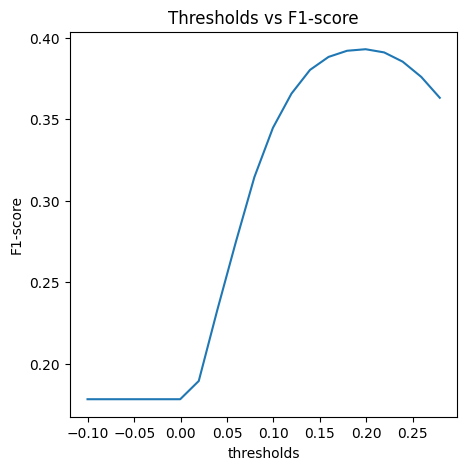

In [74]:
plt.figure(figsize=(5,5))
sns.lineplot(x=threshold_values ,y= f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()

In [75]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores)
     )

Best threshold:  0.19943034113832622
Best F1-Score:  0.3929592313058255


In [76]:
# Initializing the model

# {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 7}
rfc_model = RandomForestClassifier(n_estimators=800,max_depth=7,min_samples_leaf=10,min_samples_split=2,n_jobs=-1,verbose=10)

#fitting the model.
rfc_model.fit(X_train, y_train)

#prediction
y_pred_train = (rfc_model.predict_proba(X_train)[:, 1] >= 0.20).astype('int') #setting a threshold.
y_pred_test = (rfc_model.predict_proba(X_test)[:, 1] >= 0.20).astype('int') #setting a threshold.


#Evaluation.
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_val)))
print("-"*50)
print(classification_report(y_pred_test, y_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 800building tree 2 of 800

building tree 3 of 800
building tree 4 of 800
building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s


building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.3s


building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.5s


building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.2s


building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.8s


building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 800
building tree 47 of 800
building tree 48 of 800
building tree 49 of 800
building tree 50 of 800
building tree 51 of 800
building tree 52 of 800
building tree 53 of 800


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min


building tree 54 of 800
building tree 55 of 800
building tree 56 of 800
building tree 57 of 800
building tree 58 of 800
building tree 59 of 800
building tree 60 of 800
building tree 61 of 800building tree 62 of 800

building tree 63 of 800
building tree 64 of 800


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min


building tree 65 of 800
building tree 66 of 800
building tree 67 of 800
building tree 68 of 800
building tree 69 of 800
building tree 70 of 800
building tree 71 of 800
building tree 72 of 800
building tree 73 of 800
building tree 74 of 800
building tree 75 of 800
building tree 76 of 800
building tree 77 of 800


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min


building tree 78 of 800
building tree 79 of 800
building tree 80 of 800
building tree 81 of 800
building tree 82 of 800
building tree 83 of 800
building tree 84 of 800
building tree 85 of 800
building tree 86 of 800
building tree 87 of 800
building tree 88 of 800
building tree 89 of 800
building tree 90 of 800
building tree 91 of 800
building tree 92 of 800
building tree 93 of 800


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min


building tree 94 of 800
building tree 95 of 800
building tree 96 of 800
building tree 97 of 800
building tree 98 of 800
building tree 99 of 800
building tree 100 of 800
building tree 101 of 800
building tree 102 of 800
building tree 103 of 800
building tree 104 of 800
building tree 105 of 800


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.2min


building tree 106 of 800
building tree 107 of 800
building tree 108 of 800
building tree 109 of 800
building tree 110 of 800
building tree 111 of 800
building tree 112 of 800
building tree 113 of 800
building tree 114 of 800
building tree 115 of 800
building tree 116 of 800
building tree 117 of 800
building tree 118 of 800
building tree 119 of 800
building tree 120 of 800


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.5min


building tree 121 of 800
building tree 122 of 800
building tree 123 of 800
building tree 124 of 800
building tree 125 of 800
building tree 126 of 800
building tree 127 of 800
building tree 128 of 800
building tree 129 of 800
building tree 130 of 800
building tree 131 of 800
building tree 132 of 800
building tree 133 of 800
building tree 134 of 800
building tree 135 of 800
building tree 136 of 800
building tree 137 of 800
building tree 138 of 800


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.9min


building tree 139 of 800
building tree 140 of 800
building tree 141 of 800
building tree 142 of 800
building tree 143 of 800
building tree 144 of 800
building tree 145 of 800
building tree 146 of 800
building tree 147 of 800
building tree 148 of 800
building tree 149 of 800
building tree 150 of 800
building tree 151 of 800
building tree 152 of 800
building tree 153 of 800
building tree 154 of 800


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min


building tree 155 of 800
building tree 156 of 800
building tree 157 of 800
building tree 158 of 800
building tree 159 of 800
building tree 160 of 800
building tree 161 of 800
building tree 162 of 800
building tree 163 of 800
building tree 164 of 800
building tree 165 of 800
building tree 166 of 800
building tree 167 of 800
building tree 168 of 800
building tree 169 of 800
building tree 170 of 800
building tree 171 of 800
building tree 172 of 800
building tree 173 of 800


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.6min


building tree 174 of 800
building tree 175 of 800
building tree 176 of 800
building tree 177 of 800
building tree 178 of 800
building tree 179 of 800
building tree 180 of 800
building tree 181 of 800
building tree 182 of 800
building tree 183 of 800
building tree 184 of 800
building tree 185 of 800
building tree 186 of 800
building tree 187 of 800
building tree 188 of 800
building tree 189 of 800
building tree 190 of 800
building tree 191 of 800
building tree 192 of 800


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min


building tree 193 of 800
building tree 194 of 800
building tree 195 of 800
building tree 196 of 800
building tree 197 of 800
building tree 198 of 800
building tree 199 of 800
building tree 200 of 800
building tree 201 of 800
building tree 202 of 800
building tree 203 of 800
building tree 204 of 800
building tree 205 of 800
building tree 206 of 800
building tree 207 of 800
building tree 208 of 800
building tree 209 of 800
building tree 210 of 800
building tree 211 of 800
building tree 212 of 800
building tree 213 of 800
building tree 214 of 800


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  4.6min


building tree 215 of 800
building tree 216 of 800
building tree 217 of 800
building tree 218 of 800
building tree 219 of 800
building tree 220 of 800
building tree 221 of 800
building tree 222 of 800
building tree 223 of 800
building tree 224 of 800
building tree 225 of 800
building tree 226 of 800
building tree 227 of 800
building tree 228 of 800
building tree 229 of 800
building tree 230 of 800
building tree 231 of 800
building tree 232 of 800
building tree 233 of 800
building tree 234 of 800


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  5.1min


building tree 235 of 800
building tree 236 of 800
building tree 237 of 800
building tree 238 of 800
building tree 239 of 800
building tree 240 of 800
building tree 241 of 800
building tree 242 of 800
building tree 243 of 800
building tree 244 of 800
building tree 245 of 800
building tree 246 of 800
building tree 247 of 800
building tree 248 of 800
building tree 249 of 800
building tree 250 of 800
building tree 251 of 800
building tree 252 of 800
building tree 253 of 800
building tree 254 of 800
building tree 255 of 800
building tree 256 of 800
building tree 257 of 800


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  5.5min


building tree 258 of 800
building tree 259 of 800
building tree 260 of 800
building tree 261 of 800
building tree 262 of 800
building tree 263 of 800
building tree 264 of 800
building tree 265 of 800
building tree 266 of 800
building tree 267 of 800
building tree 268 of 800
building tree 269 of 800
building tree 270 of 800
building tree 271 of 800
building tree 272 of 800
building tree 273 of 800
building tree 274 of 800
building tree 275 of 800
building tree 276 of 800
building tree 277 of 800
building tree 278 of 800
building tree 279 of 800
building tree 280 of 800


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.0min


building tree 281 of 800
building tree 282 of 800
building tree 283 of 800
building tree 284 of 800
building tree 285 of 800
building tree 286 of 800
building tree 287 of 800
building tree 288 of 800
building tree 289 of 800
building tree 290 of 800
building tree 291 of 800
building tree 292 of 800
building tree 293 of 800
building tree 294 of 800
building tree 295 of 800
building tree 296 of 800
building tree 297 of 800
building tree 298 of 800
building tree 299 of 800
building tree 300 of 800
building tree 301 of 800
building tree 302 of 800
building tree 303 of 800
building tree 304 of 800
building tree 305 of 800


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  6.6min


building tree 306 of 800
building tree 307 of 800
building tree 308 of 800
building tree 309 of 800
building tree 310 of 800
building tree 311 of 800
building tree 312 of 800
building tree 313 of 800
building tree 314 of 800
building tree 315 of 800
building tree 316 of 800
building tree 317 of 800
building tree 318 of 800
building tree 319 of 800
building tree 320 of 800
building tree 321 of 800
building tree 322 of 800
building tree 323 of 800
building tree 324 of 800
building tree 325 of 800
building tree 326 of 800
building tree 327 of 800
building tree 328 of 800
building tree 329 of 800
building tree 330 of 800


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  7.2min


building tree 331 of 800
building tree 332 of 800
building tree 333 of 800
building tree 334 of 800
building tree 335 of 800
building tree 336 of 800
building tree 337 of 800
building tree 338 of 800
building tree 339 of 800
building tree 340 of 800
building tree 341 of 800
building tree 342 of 800
building tree 343 of 800
building tree 344 of 800
building tree 345 of 800
building tree 346 of 800
building tree 347 of 800
building tree 348 of 800
building tree 349 of 800
building tree 350 of 800
building tree 351 of 800
building tree 352 of 800
building tree 353 of 800
building tree 354 of 800
building tree 355 of 800
building tree 356 of 800
building tree 357 of 800


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.7min


building tree 358 of 800
building tree 359 of 800
building tree 360 of 800
building tree 361 of 800
building tree 362 of 800
building tree 363 of 800
building tree 364 of 800
building tree 365 of 800
building tree 366 of 800
building tree 367 of 800
building tree 368 of 800
building tree 369 of 800
building tree 370 of 800
building tree 371 of 800
building tree 372 of 800
building tree 373 of 800
building tree 374 of 800
building tree 375 of 800
building tree 376 of 800
building tree 377 of 800
building tree 378 of 800
building tree 379 of 800
building tree 380 of 800
building tree 381 of 800
building tree 382 of 800
building tree 383 of 800
building tree 384 of 800


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  8.3min


building tree 385 of 800
building tree 386 of 800
building tree 387 of 800
building tree 388 of 800
building tree 389 of 800
building tree 390 of 800
building tree 391 of 800
building tree 392 of 800
building tree 393 of 800
building tree 394 of 800
building tree 395 of 800
building tree 396 of 800
building tree 397 of 800
building tree 398 of 800
building tree 399 of 800
building tree 400 of 800
building tree 401 of 800
building tree 402 of 800
building tree 403 of 800
building tree 404 of 800
building tree 405 of 800
building tree 406 of 800building tree 407 of 800

building tree 408 of 800
building tree 409 of 800
building tree 410 of 800
building tree 411 of 800
building tree 412 of 800
building tree 413 of 800


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  9.0min


building tree 414 of 800
building tree 415 of 800
building tree 416 of 800
building tree 417 of 800
building tree 418 of 800
building tree 419 of 800
building tree 420 of 800
building tree 421 of 800
building tree 422 of 800
building tree 423 of 800
building tree 424 of 800
building tree 425 of 800
building tree 426 of 800
building tree 427 of 800
building tree 428 of 800
building tree 429 of 800
building tree 430 of 800
building tree 431 of 800
building tree 432 of 800
building tree 433 of 800
building tree 434 of 800
building tree 435 of 800
building tree 436 of 800
building tree 437 of 800
building tree 438 of 800
building tree 439 of 800
building tree 440 of 800
building tree 441 of 800
building tree 442 of 800


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.6min


building tree 443 of 800
building tree 444 of 800
building tree 445 of 800
building tree 446 of 800
building tree 447 of 800
building tree 448 of 800
building tree 449 of 800
building tree 450 of 800
building tree 451 of 800
building tree 452 of 800
building tree 453 of 800
building tree 454 of 800
building tree 455 of 800
building tree 456 of 800
building tree 457 of 800
building tree 458 of 800
building tree 459 of 800
building tree 460 of 800
building tree 461 of 800
building tree 462 of 800
building tree 463 of 800
building tree 464 of 800
building tree 465 of 800
building tree 466 of 800
building tree 467 of 800
building tree 468 of 800
building tree 469 of 800
building tree 470 of 800
building tree 471 of 800
building tree 472 of 800
building tree 473 of 800


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 10.2min


building tree 474 of 800
building tree 475 of 800
building tree 476 of 800
building tree 477 of 800
building tree 478 of 800
building tree 479 of 800
building tree 480 of 800
building tree 481 of 800
building tree 482 of 800
building tree 483 of 800
building tree 484 of 800
building tree 485 of 800
building tree 486 of 800
building tree 487 of 800
building tree 488 of 800
building tree 489 of 800
building tree 490 of 800
building tree 491 of 800
building tree 492 of 800
building tree 493 of 800
building tree 494 of 800
building tree 495 of 800
building tree 496 of 800
building tree 497 of 800
building tree 498 of 800
building tree 499 of 800
building tree 500 of 800
building tree 501 of 800
building tree 502 of 800
building tree 503 of 800
building tree 504 of 800


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 10.9min


building tree 505 of 800
building tree 506 of 800
building tree 507 of 800
building tree 508 of 800
building tree 509 of 800
building tree 510 of 800
building tree 511 of 800
building tree 512 of 800
building tree 513 of 800
building tree 514 of 800
building tree 515 of 800
building tree 516 of 800
building tree 517 of 800
building tree 518 of 800
building tree 519 of 800
building tree 520 of 800
building tree 521 of 800
building tree 522 of 800
building tree 523 of 800
building tree 524 of 800
building tree 525 of 800
building tree 526 of 800
building tree 527 of 800
building tree 528 of 800
building tree 529 of 800
building tree 530 of 800
building tree 531 of 800
building tree 532 of 800
building tree 533 of 800
building tree 534 of 800
building tree 535 of 800
building tree 536 of 800
building tree 537 of 800


[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 11.6min


building tree 538 of 800
building tree 539 of 800
building tree 540 of 800
building tree 541 of 800
building tree 542 of 800
building tree 543 of 800
building tree 544 of 800
building tree 545 of 800
building tree 546 of 800
building tree 547 of 800
building tree 548 of 800
building tree 549 of 800
building tree 550 of 800
building tree 551 of 800
building tree 552 of 800
building tree 553 of 800
building tree 554 of 800
building tree 555 of 800
building tree 556 of 800
building tree 557 of 800
building tree 558 of 800
building tree 559 of 800
building tree 560 of 800
building tree 561 of 800
building tree 562 of 800
building tree 563 of 800
building tree 564 of 800
building tree 565 of 800
building tree 566 of 800
building tree 567 of 800
building tree 568 of 800
building tree 569 of 800
building tree 570 of 800


[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 12.3min


building tree 571 of 800
building tree 572 of 800
building tree 573 of 800
building tree 574 of 800
building tree 575 of 800
building tree 576 of 800
building tree 577 of 800
building tree 578 of 800
building tree 579 of 800
building tree 580 of 800
building tree 581 of 800
building tree 582 of 800
building tree 583 of 800
building tree 584 of 800
building tree 585 of 800
building tree 586 of 800
building tree 587 of 800
building tree 588 of 800
building tree 589 of 800
building tree 590 of 800
building tree 591 of 800
building tree 592 of 800
building tree 593 of 800
building tree 594 of 800
building tree 595 of 800
building tree 596 of 800
building tree 597 of 800
building tree 598 of 800
building tree 599 of 800
building tree 600 of 800
building tree 601 of 800
building tree 602 of 800
building tree 603 of 800
building tree 604 of 800
building tree 605 of 800


[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 13.2min


building tree 606 of 800
building tree 607 of 800
building tree 608 of 800
building tree 609 of 800
building tree 610 of 800
building tree 611 of 800
building tree 612 of 800
building tree 613 of 800
building tree 614 of 800
building tree 615 of 800
building tree 616 of 800
building tree 617 of 800
building tree 618 of 800
building tree 619 of 800
building tree 620 of 800
building tree 621 of 800
building tree 622 of 800
building tree 623 of 800
building tree 624 of 800
building tree 625 of 800
building tree 626 of 800
building tree 627 of 800
building tree 628 of 800
building tree 629 of 800
building tree 630 of 800
building tree 631 of 800
building tree 632 of 800
building tree 633 of 800
building tree 634 of 800
building tree 635 of 800
building tree 636 of 800
building tree 637 of 800
building tree 638 of 800
building tree 639 of 800
building tree 640 of 800


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 13.9min


building tree 641 of 800
building tree 642 of 800
building tree 643 of 800
building tree 644 of 800
building tree 645 of 800
building tree 646 of 800
building tree 647 of 800
building tree 648 of 800
building tree 649 of 800
building tree 650 of 800
building tree 651 of 800
building tree 652 of 800
building tree 653 of 800
building tree 654 of 800
building tree 655 of 800
building tree 656 of 800
building tree 657 of 800
building tree 658 of 800
building tree 659 of 800
building tree 660 of 800
building tree 661 of 800
building tree 662 of 800
building tree 663 of 800
building tree 664 of 800
building tree 665 of 800
building tree 666 of 800
building tree 667 of 800
building tree 668 of 800
building tree 669 of 800
building tree 670 of 800
building tree 671 of 800
building tree 672 of 800
building tree 673 of 800
building tree 674 of 800
building tree 675 of 800
building tree 676 of 800
building tree 677 of 800


[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 14.7min


building tree 678 of 800
building tree 679 of 800
building tree 680 of 800
building tree 681 of 800
building tree 682 of 800
building tree 683 of 800
building tree 684 of 800
building tree 685 of 800
building tree 686 of 800
building tree 687 of 800
building tree 688 of 800
building tree 689 of 800
building tree 690 of 800
building tree 691 of 800
building tree 692 of 800
building tree 693 of 800
building tree 694 of 800
building tree 695 of 800
building tree 696 of 800
building tree 697 of 800
building tree 698 of 800
building tree 699 of 800
building tree 700 of 800
building tree 701 of 800
building tree 702 of 800
building tree 703 of 800
building tree 704 of 800
building tree 705 of 800
building tree 706 of 800
building tree 707 of 800
building tree 708 of 800
building tree 709 of 800
building tree 710 of 800
building tree 711 of 800
building tree 712 of 800
building tree 713 of 800
building tree 714 of 800


[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 15.4min


building tree 715 of 800
building tree 716 of 800
building tree 717 of 800
building tree 718 of 800
building tree 719 of 800
building tree 720 of 800
building tree 721 of 800
building tree 722 of 800
building tree 723 of 800
building tree 724 of 800
building tree 725 of 800
building tree 726 of 800
building tree 727 of 800
building tree 728 of 800
building tree 729 of 800
building tree 730 of 800
building tree 731 of 800
building tree 732 of 800
building tree 733 of 800
building tree 734 of 800
building tree 735 of 800
building tree 736 of 800
building tree 737 of 800
building tree 738 of 800
building tree 739 of 800
building tree 740 of 800
building tree 741 of 800
building tree 742 of 800
building tree 743 of 800
building tree 744 of 800
building tree 745 of 800
building tree 746 of 800
building tree 747 of 800
building tree 748 of 800
building tree 749 of 800
building tree 750 of 800
building tree 751 of 800
building tree 752 of 800
building tree 753 of 800


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 16.3min


building tree 754 of 800
building tree 755 of 800
building tree 756 of 800
building tree 757 of 800
building tree 758 of 800
building tree 759 of 800
building tree 760 of 800
building tree 761 of 800
building tree 762 of 800
building tree 763 of 800
building tree 764 of 800
building tree 765 of 800
building tree 766 of 800
building tree 767 of 800
building tree 768 of 800
building tree 769 of 800
building tree 770 of 800
building tree 771 of 800
building tree 772 of 800
building tree 773 of 800
building tree 774 of 800
building tree 775 of 800
building tree 776 of 800
building tree 777 of 800
building tree 778 of 800
building tree 779 of 800
building tree 780 of 800
building tree 781 of 800
building tree 782 of 800
building tree 783 of 800
building tree 784 of 800
building tree 785 of 800
building tree 786 of 800
building tree 787 of 800
building tree 788 of 800
building tree 789 of 800
building tree 790 of 800
building tree 791 of 800
building tree 792 of 800


[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 17.1min


building tree 793 of 800
building tree 794 of 800
building tree 795 of 800
building tree 796 of 800
building tree 797 of 800
building tree 798 of 800
building tree 799 of 800
building tree 800 of 800


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 17.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   1

NameError: name 'X_test' is not defined

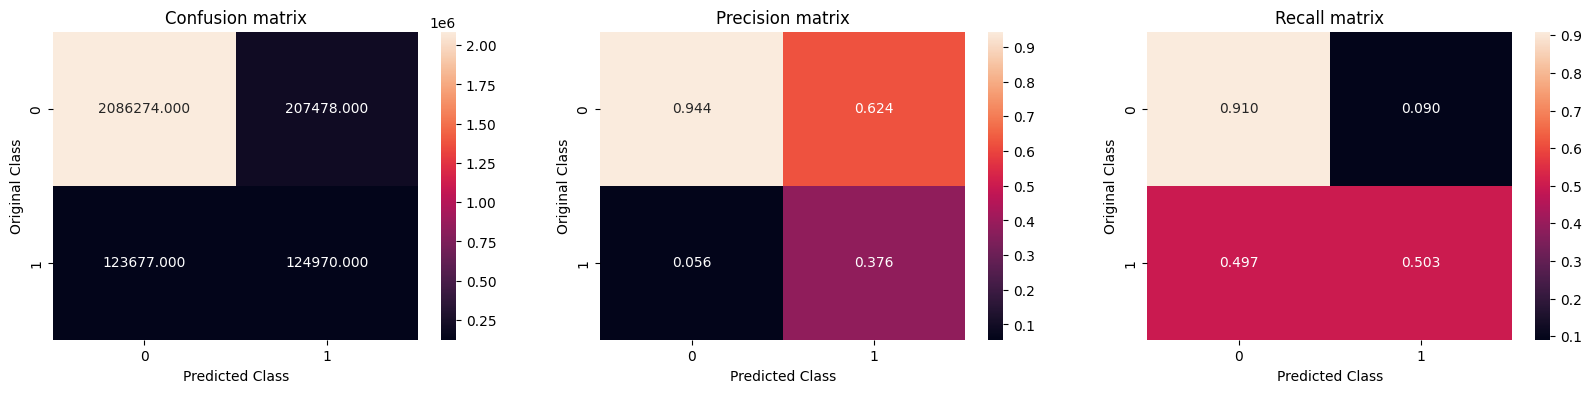

In [77]:
# Confusion, Precision and Recall matrix
plot_confusion_matrix(y_val,y_pred_test)

In [78]:
pickle.dump(rfc_model, open("data/rfc_model", 'wb'))

### Decision Tree

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': range(3,10),
    'min_samples_split' : range(1,10),
    'min_samples_leaf' : range(1,5) 
}
# Create a based model
rf = DecisionTreeClassifier()

# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START max_depth=6, min_samples_leaf=1, min_samples_split=9.......
[CV 1/3; 1/10] END max_depth=6, min_samples_leaf=1, min_samples_split=9;, score=0.905 total time=  32.7s
[CV 3/3; 4/10] START max_depth=4, min_samples_leaf=3, min_samples_split=7.......
[CV 3/3; 4/10] END max_depth=4, min_samples_leaf=3, min_samples_split=7;, score=0.903 total time=  21.6s
[CV 3/3; 2/10] START max_depth=3, min_samples_leaf=2, min_samples_split=3.......
[CV 3/3; 2/10] END max_depth=3, min_samples_leaf=2, min_samples_split=3;, score=0.903 total time=  18.8s
[CV 1/3; 4/10] START max_depth=4, min_samples_leaf=3, min_samples_split=7.......
[CV 1/3; 4/10] END max_depth=4, min_samples_leaf=3, min_samples_split=7;, score=0.903 total time=  21.3s
[CV 3/3; 5/10] START max_depth=7, min_samples_leaf=3, min_samples_split=2.......
[CV 3/3; 5/10] END max_depth=7, min_samples_leaf=3, min_samples_split=2;, score=0.906 total time=  36.6s
[CV 2/3; 

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': range(3, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(1, 10)},
                   verbose=10)

In [80]:
# Best  parameters
random_search.best_params_

{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 9}

In [82]:
# To get the best threshold for max F1 score

# Initializing the model
dtc_model = DecisionTreeClassifier(max_depth=9,min_samples_leaf=4,min_samples_split=5)
dtc_model.fit(X_train,y_train)
thresholds = dtc_model.predict_proba(X_val)[:, 1]

[CV 2/3; 2/10] START max_depth=3, min_samples_leaf=2, min_samples_split=3.......
[CV 2/3; 2/10] END max_depth=3, min_samples_leaf=2, min_samples_split=3;, score=0.903 total time=  18.8s
[CV 2/3; 4/10] START max_depth=4, min_samples_leaf=3, min_samples_split=7.......
[CV 2/3; 4/10] END max_depth=4, min_samples_leaf=3, min_samples_split=7;, score=0.903 total time=  21.4s
[CV 1/3; 6/10] START max_depth=9, min_samples_leaf=3, min_samples_split=6.......
[CV 1/3; 6/10] END max_depth=9, min_samples_leaf=3, min_samples_split=6;, score=0.907 total time=  45.8s
[CV 3/3; 8/10] START max_depth=8, min_samples_leaf=3, min_samples_split=7.......
[CV 3/3; 8/10] END max_depth=8, min_samples_leaf=3, min_samples_split=7;, score=0.907 total time=  40.7s
[CV 1/3; 7/10] START max_depth=7, min_samples_leaf=1, min_samples_split=2.......
[CV 1/3; 7/10] END max_depth=7, min_samples_leaf=1, min_samples_split=2;, score=0.906 total time=  36.0s
[CV 1/3; 9/10] START max_depth=9, min_samples_leaf=4, min_samples_spli

In [83]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [84]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)

0.09792332403365937
0.12356974220939317
0.3450628084524457
-0.14921616038512697


In [86]:
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (lgbm.predict_proba(X_val)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_val , y_pred))

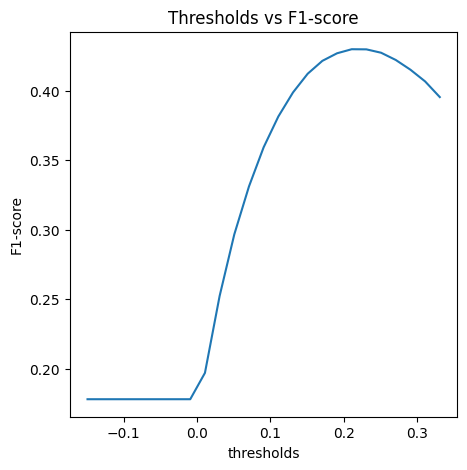

In [88]:
plt.figure(figsize=(5,5))
sns.lineplot(x=threshold_values , y=f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()

In [89]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.21078383961487285
Best F1-Score:  0.4298353690380218


In [ ]:
{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 9}

In [91]:
# Initializing the model
dtc_model = DecisionTreeClassifier(max_depth=9,min_samples_leaf=4,min_samples_split=5)

#fitting the model.
dtc_model.fit(X_train, y_train)

#prediction
y_pred_train = (dtc_model.predict_proba(X_train)[:, 1] >= 0.22).astype('int') #setting a threshold.
y_pred_test = (dtc_model.predict_proba(X_val)[:, 1] >= 0.22).astype('int') #setting a threshold.

#Evaluation.
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_val)))

print("-"*50)
print(classification_report(y_pred_test, y_val))

Train F1 Score: 0.41576979893218047
Validation F1 Score: 0.41363412639115604
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2226228
           1       0.47      0.37      0.41    316171

    accuracy                           0.87   2542399
   macro avg       0.69      0.66      0.67   2542399
weighted avg       0.86      0.87      0.86   2542399



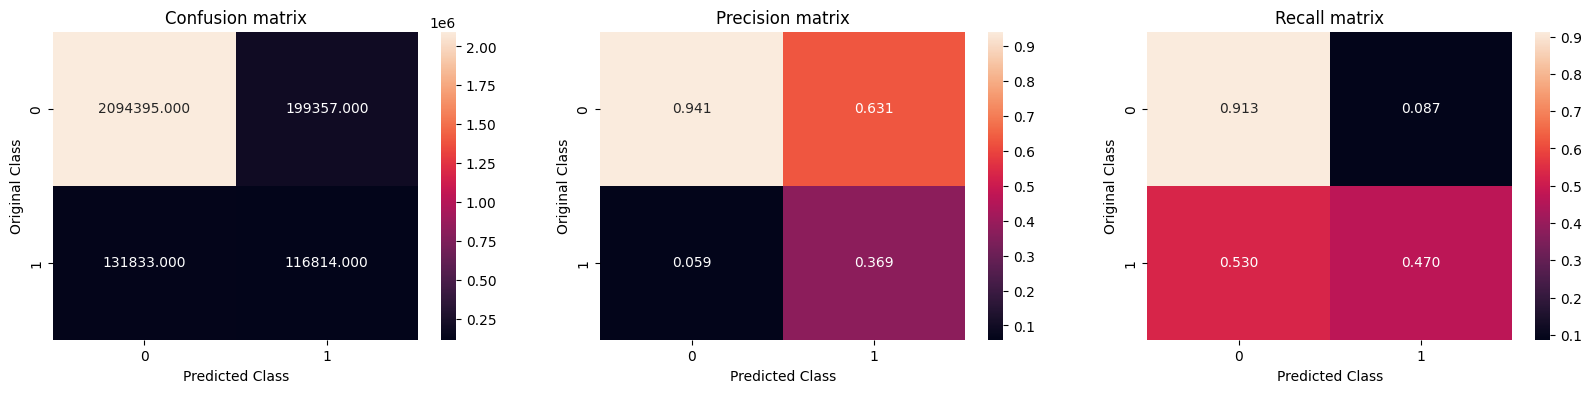

In [92]:
# Confusion, Precision and Recall matrix
plot_confusion_matrix(y_val,y_pred_test)

In [93]:
pickle.dump(dtc_model, open("model/dtc_model", 'wb'))